<a href="https://colab.research.google.com/github/bitblayde/Machine-and-Deep-learning-projects/blob/main/Computer_Vision/Semantic_Segmentation_simple_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

fatal: destination path 'clothing-co-parsing' already exists and is not an empty directory.


In [4]:
!ls ./clothing-co-parsing/photos | wc -l

2098


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import scipy.io
import math
import cv2
import os

photos_path = "./clothing-co-parsing/photos/"
masks_path = "./clothing-co-parsing/annotations/pixel-level/"

In [6]:
img_files = sorted([f for f in os.listdir(photos_path) if os.path.isfile(os.path.join(photos_path, f))])
mask_files = sorted([f for f in os.listdir(masks_path) if os.path.isfile(os.path.join(masks_path, f))])

imgs_clf, masks_clf = [], []
for img, mask in zip(img_files, mask_files):
    nimg = plt.imread(photos_path+img)
    
    imgs_clf.append( tf.cast(tf.image.resize(nimg, (256, 256)), tf.float32)/255. )
    
    current_img = scipy.io.loadmat(masks_path+mask)
    nmasks = current_img["groundtruth"]
    
    nmasks = nmasks[..., np.newaxis]
    masks_clf.append(tf.cast(tf.image.resize(nmasks, (256, 256)), tf.uint8))
    
masks_clf[0].shape, imgs_clf[0].shape

(TensorShape([256, 256, 1]), TensorShape([256, 256, 3]))

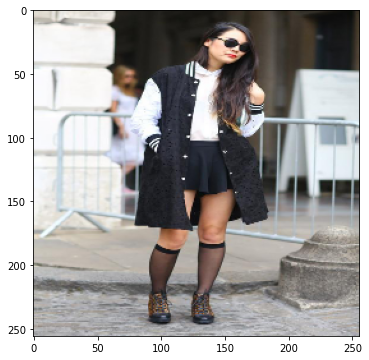

In [7]:
def plot_image(img, title = "", cmap="hot"):
    plt.title(title)
    plt.imshow(img, cmap=cmap)

plt.figure(figsize=(8, 6))
plot_image(imgs_clf[0])
plt.show()

What if we use a simple approach as a basic clustering algorithm such as K-Mean?

In [8]:
from sklearn.cluster import KMeans

idx = np.random.randint(0, 999)
example = imgs_clf[0]
example = example.numpy().reshape(-1, 3)

In [9]:
kmeans = KMeans(n_clusters=4).fit(example)
segmented_image = kmeans.cluster_centers_[kmeans.labels_]

segmented_image = segmented_image.reshape(imgs_clf[0].shape )
segmented_image = tf.image.resize(segmented_image, (256, 256)).numpy()

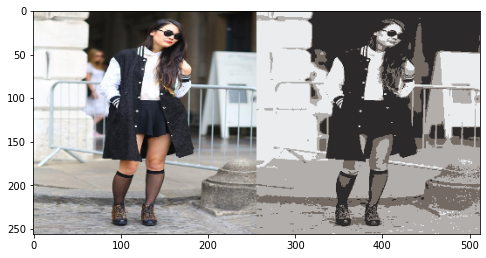

In [10]:
sample = np.concatenate([imgs_clf[0], segmented_image], axis=1)

plt.figure(figsize=(8, 6))
plot_image(sample)
plt.show()

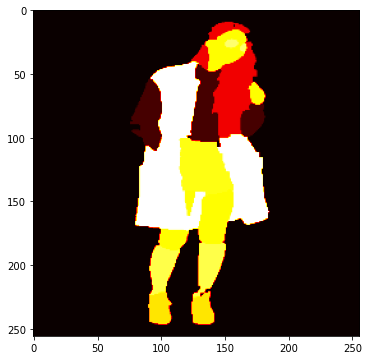

In [11]:
plt.figure(figsize=(8, 6))
plot_image(masks_clf[0][..., 0])
plt.show()

In [12]:
idx = np.random.randint(0, 999)
tf.math.reduce_min(masks_clf[idx]).numpy(), tf.math.reduce_max(masks_clf[idx]).numpy()

(0, 47)

Train 70%, val 20%, test 10%.

In [13]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(imgs_clf, masks_clf, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
len(X_train)

722

In [14]:
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_val = tf.data.Dataset.from_tensor_slices(X_val)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_val = tf.data.Dataset.from_tensor_slices(y_val)
X_test = tf.data.Dataset.from_tensor_slices(X_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

In [15]:
tf.data.experimental.cardinality(X_test)

<tf.Tensor: shape=(), dtype=int64, numpy=101>

In [16]:
def flip_image_fn(X, y):
    X = tf.image.flip_left_right(X)
    y = tf.image.flip_left_right(y)
    return X, y

def flip_h_fn(X, y):
    X = tf.image.flip_left_right(X)
    y = tf.image.flip_left_right(y)
    return X, y

def saturate_fn(X, y):
    X = tf.image.adjust_saturation(X, 10)
    return X, y

def modify_brightness_fn(X, y):
    X = tf.image.adjust_brightness(X, 0.5)
    return X, y

def center_crop_fn(X, y):
    X = tf.image.central_crop(X, central_fraction=0.5)
    X = tf.image.resize(X, (256, 256))
    
    y = tf.image.central_crop(y, central_fraction=0.5)
    y = tf.image.resize(y, (256, 256))
    return tf.cast(X, tf.float32), tf.cast(y, tf.uint8)


def rot90_fn(X, y):
    X = tf.image.rot90(X)
    y = tf.image.rot90(y)
    return X, y


train = tf.data.Dataset.zip((X_train, y_train))
validation = tf.data.Dataset.zip((X_val, y_val))
test = tf.data.Dataset.zip((X_test, y_test))

flip = train.map(flip_image_fn)
flip_h = train.map(flip_h_fn)
saturate = train.map(saturate_fn)
saturate4 = train.map(saturate_fn)
brightness = train.map(modify_brightness_fn)
center_crop = train.map(center_crop_fn)
rot90 = train.map(rot90_fn)

train = train.concatenate(flip)
train = train.concatenate(flip_h)
train = train.concatenate(saturate)
train = train.concatenate(saturate4)
train = train.concatenate(brightness)
train = train.concatenate(center_crop)
train = train.concatenate(rot90)

train

<ConcatenateDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.uint8)>

In [17]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, filters, kernel, strides, activation, **kwargs):
        super().__init__(**kwargs)
        
        self.conv1 = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel, \
                                            strides = strides, padding="same", kernel_initializer="he_normal")
        
        self.bacthNorm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.Activation(activation)
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bacthNorm(x)
        x = self.activation(x)
        return x

In [18]:
class encoder(tf.keras.models.Model):
    def __init__(self, input_dim):
        super().__init__()
        # Since I gonna use fcn network could be possible to put dimensions as (None, None, c)
        self.initial_convo = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, \
                                            strides = 1, padding="same", \
                                            kernel_initializer="he_normal", input_shape=(None, None, 3))
        
        self.convo_block1 = convolutional_block(64, 3, 2, "relu") ## /2
        self.convo_block2 = convolutional_block(128, 3, 4, "relu") ## /4
        self.maxpool = tf.keras.layers.MaxPool2D((2, 2)) # /2
        self.convo_block3 = convolutional_block(128, 3, 2, "relu") ## /2
        self.convo_block4 = convolutional_block(256, 3, 2, "relu") ## /6
        
    def call(self, inputs):
        x = self.initial_convo(inputs)
        x = self.convo_block1(x)
        x = self.convo_block2(x)
        x = self.maxpool(x)
        x = self.convo_block3(x)
        x = self.convo_block4(x)
        return x

In [19]:
class decoder(tf.keras.models.Model):
    def __init__(self, output_classes):
        super().__init__()
        self.transpose1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation="relu")
        self.transpose2 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same", activation="relu")
        self.upsample1 = tf.keras.layers.UpSampling2D((2, 2))
        self.transpose3 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=4, padding="same", activation="relu")
        self.transpose4 = tf.keras.layers.Conv2DTranspose(filters=output_classes, kernel_size=3, strides=2, padding="same", activation="softmax")
    def call(self, x):
        x = self.transpose1(x)
        x = self.transpose2(x)
        x = self.upsample1(x)
        x = self.transpose3(x)
        x = self.transpose4(x)
        
        return x

In [20]:
class Encoder_Decoder(tf.keras.models.Model):
    def __init__(self, input_dim, output_classes):
        super().__init__()
        self.input_dim = input_dim
        self.output_classes = output_classes
        self.encoder = encoder(self.input_dim)
        self.decoder = decoder(self.output_classes)
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def model(self):
        x = tf.keras.Input(self.input_dim)
        return tf.keras.models.Model(inputs=[x], outputs=self.call(x))

In [21]:
batch = 32

steps_per_epoch = tf.data.experimental.cardinality(train).numpy() // batch

train = train.cache().shuffle(tf.data.experimental.cardinality(train).numpy()).batch(batch).repeat()
train = train.prefetch(tf.data.experimental.AUTOTUNE)
validation = validation.batch(batch)
test = test.batch(batch)
train

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>

In [22]:
tf.keras.backend.clear_session()

n_classes = 59
model = Encoder_Decoder(input_dim = imgs_clf[0].shape, output_classes=n_classes)
model.build((None, *imgs_clf[0].shape))

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
epochs = 25
model.model().summary()
model.fit(train, validation_data=validation, batch_size=batch, epochs=epochs, steps_per_epoch=steps_per_epoch)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder (encoder)            (None, 4, 4, 256)         538304    
_________________________________________________________________
decoder (decoder)            (None, 256, 256, 59)      329211    
Total params: 867,515
Trainable params: 866,363
Non-trainable params: 1,152
_________________________________________________________________
Epoch 1/25
180/180 [==============================] - 84s 256ms/step - loss: 1.8279 - accuracy: 0.7088 - val_loss: 1.2739 - val_accuracy: 0.7686
Epoch 2/25
180/180 [==============================] - 48s 264ms/step - loss: 1.2311 - accuracy: 0.7173 - val_loss: 0.9611 - val_accuracy: 0.7758
Epoch 3/25
180/180 [==============================] - 48s 267ms/step - loss: 1.1109 - accur

In [29]:
def make_prediction(data, model):
    test1 = next(iter(data))
    predictions = model.predict(test1[0])
    pred_mask = tf.argmax(predictions, axis=-1)
    plt.imshow(pred_mask[1])

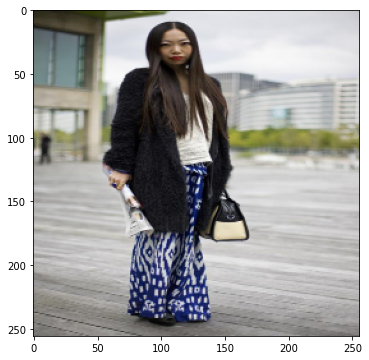

In [30]:
test_img = next(iter(test))[0][1]

plt.figure(figsize=(8, 6))
plot_image(test_img)
plt.show()

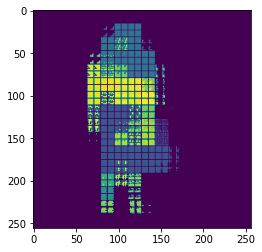

In [31]:
make_prediction(test, model)